# Update HotMaps Industry database with new entries from the EU-ETS database

The hotmaps project finished in 2015, so there are new sites to be scraped from the EU-ETS database!
Here we add only those that do not already exist in HotMaps.

In [1]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt 

import seaborn as sns
import matplotlib.lines as mlines

sys.path.append('../../src/construct/')
import util

idx = pd.IndexSlice

data_path = '../../data/industry'

_subsectors = {
    'Chemical & petrochemical': 'Chemicals Industry',
    'Food, beverages & tobacco': 'Food, beverages and tobacco',
    'Iron & steel': 'Iron and steel',
    'Machinery': 'Machinery Equipment',
    'Non-ferrous metals': 'Non Ferrous Metals',
    'Non-metallic minerals': 'Non-metallic mineral products',
    'Not elsewhere specified (industry)': 'Other Industrial Sectors',
    'Mining & quarrying': 'Other Industrial Sectors',
    'Construction': 'Other Industrial Sectors',
    'Paper, pulp & printing': 'Pulp, paper and printing',
    'Textile & leather': 'Textiles and leather',
    'Transport equipment': 'Transport Equipment',
    'Wood & wood products': 'Wood and wood products',
}

In [2]:
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
cat_names = {k: _subsectors[v] if v in _subsectors.keys() else v for k, v in subsectors.sub_cat_2.fillna(subsectors.sub_cat_1).to_dict().items()}
hotmaps_industrial_sites = pd.read_csv(data_path + '/Industrial_Database.csv', delimiter=';')
ets_industrial_sites = pd.read_csv(
    data_path + '/industry/industrial_plant_metadata.csv', 
    usecols=['REGISTRY_COD', 'MAIN_ACTIVITY_TYPE_CODE', 'lat', 'lon', 'PERMIT_IDENTIFIER', 'INSTALLATION_NAME']
).set_index('PERMIT_IDENTIFIER')
industrial_emissions = pd.read_csv(data_path + '/industrial_emissions.csv', index_col=0)['2014']
industrial_activity_codes = pd.read_csv(
    data_path + '/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

In [3]:
hotmaps_industrial_sites = pd.read_csv(data_path + '/Industrial_Database.csv', delimiter=';')
geoms = hotmaps_industrial_sites.geom.str.split(';', expand=True)[1].dropna().apply(wkt.loads)
hotmap_industrial_points = gpd.GeoDataFrame(hotmaps_industrial_sites.drop('geom', axis=1).loc[geoms.index], geometry=geoms, crs='epsg:4326')

hotmap_industrial_points = (
    hotmap_industrial_points
    .replace({
        'Cement': 'Non-metallic mineral products',
        'Paper and printing': 'Pulp, paper and printing',
        'Non-ferrous metals': 'Non Ferrous Metals',
        'Chemical industry': 'Chemicals Industry',
        'Glass': 'Non-metallic mineral products',
        'Other non-classified': 'Other Industrial Sectors',
        'Refineries': np.nan
    })
    .dropna(subset=['Subsector'])
)
hotmap_industrial_points['Country'] = hotmap_industrial_points.Country.map(lambda x: util.get_alpha2(x) if x != 'Netherland' else util.get_alpha2('netherlands'))
hotmap_industrial_points['emissions'] = hotmap_industrial_points.Emissions_ETS_2014.fillna(hotmap_industrial_points.Emissions_EPRTR_2014)
hotmap_industrial_points = hotmap_industrial_points[hotmap_industrial_points.emissions > 0].dropna(subset=['emissions'])

In [4]:
# Load scraped data and reorganise things

ind_pts = [Point(xy) for xy in zip(ets_industrial_sites.lon.values, ets_industrial_sites.lat.values)]
ets_industrial_points = gpd.GeoDataFrame(ets_industrial_sites.rename(columns={'REGISTRY_COD': 'country'}), geometry=ind_pts, crs='epsg:4326').drop(['lat', 'lon'], axis=1)

# Assign emissions and subsector to sites


industrial_emissions = industrial_emissions.reindex(ets_industrial_points.index)
ets_industrial_points['emissions'] = industrial_emissions.where(industrial_emissions.str.isnumeric()).astype(float)
ets_activity_codes = industrial_activity_codes['Eurostat sector'][industrial_activity_codes['Eurostat sector'].index.str.isnumeric()]
ets_activity_codes.index = ets_activity_codes.index.astype(int)
ets_industrial_points['MAIN_ACTIVITY_TYPE_CODE'] = ets_industrial_points.MAIN_ACTIVITY_TYPE_CODE.map(ets_activity_codes.to_dict())
ets_industrial_points = ets_industrial_points[ets_industrial_points.MAIN_ACTIVITY_TYPE_CODE.fillna('').str.contains('FC_IND')].dropna()
ets_industrial_points['MAIN_ACTIVITY_TYPE_CODE'] = ets_industrial_points.MAIN_ACTIVITY_TYPE_CODE.map(cat_names)

In [5]:
## Find new industry sites to add to the hotmaps list

# Find overlap with site name
idx1 = ets_industrial_points[ets_industrial_points.emissions > 0].set_index(['INSTALLATION_NAME'], append=True).index#.drop_duplicates()
idx2 = hotmap_industrial_points[hotmap_industrial_points.Emissions_ETS_2014 > 0].set_index(['SiteName']).index#.drop_duplicates()
new_units = ets_industrial_points.loc[idx1[~idx1.droplevel(0).isin(idx2)].remove_unused_levels().levels[0]]

# Find overlap with site position
new_units['coords'] = [(xy) for xy in zip(new_units.centroid.x, new_units.centroid.y)]
grouped_emissions = new_units.groupby(['MAIN_ACTIVITY_TYPE_CODE', 'coords']).sum().reindex(new_units.set_index(['MAIN_ACTIVITY_TYPE_CODE', 'coords']).index)
new_units['emissions'] = grouped_emissions.values
new_units = new_units.drop_duplicates(subset=['MAIN_ACTIVITY_TYPE_CODE', 'coords'])

points_with_buffer = gpd.GeoDataFrame(
    hotmap_industrial_points[['Emissions_ETS_2014', 'Subsector', 'SiteName']], 
    geometry=hotmap_industrial_points.to_crs('epsg:3035').buffer(2000).to_crs('epsg:4326')  # 10km radius
)
overlapping_points = gpd.overlay(new_units.reset_index(), points_with_buffer.reset_index())
overlapping_emissions_points = overlapping_points[(overlapping_points.emissions < overlapping_points.Emissions_ETS_2014 * 1.1) & (overlapping_points.emissions > overlapping_points.Emissions_ETS_2014 / 1.1)]

# Fix a few seemingly incorrectly named subsectors
disagreement_on_subsector = overlapping_emissions_points[overlapping_emissions_points.MAIN_ACTIVITY_TYPE_CODE != overlapping_emissions_points.Subsector]
new_subsectors = disagreement_on_subsector.MAIN_ACTIVITY_TYPE_CODE.replace({'Other Industrial Sectors': 'Chemicals Industry'}).fillna('Iron and steel')  # hardcoded
hotmap_industrial_points.loc[disagreement_on_subsector['index'], 'Subsector'] = new_subsectors

leftover_new_units = new_units.drop(overlapping_emissions_points.PERMIT_IDENTIFIER)

all_industrial_units = (
    hotmap_industrial_points[['geometry', 'Subsector', 'emissions', 'Country']]
    .append(
        leftover_new_units
        .rename(columns={'MAIN_ACTIVITY_TYPE_CODE': 'Subsector', 'country': 'Country'})
        [['geometry', 'Subsector', 'emissions', 'Country']], 
        ignore_index=True
    )
)
all_industrial_units['emissions_10ktCO2'] = all_industrial_units['emissions'] / 1e4

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':


In [232]:
# Save
all_industrial_units.to_file(data_path + '/industry/all_industrial_ets_eprtr_sites.geojson', driver='GeoJSON')

(1400000.0, 5500000.0)

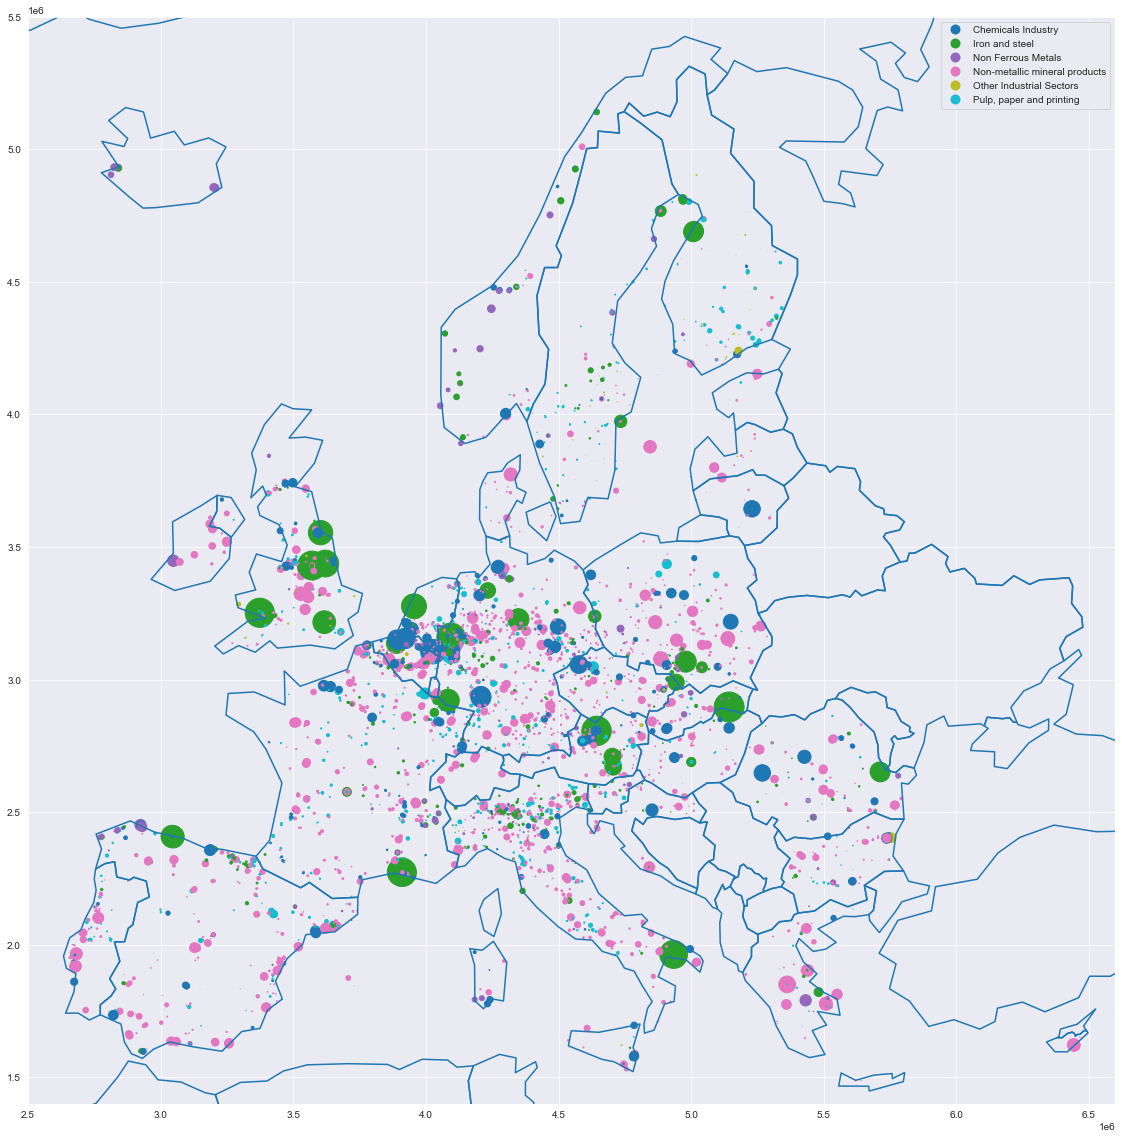

In [203]:
# Show sites
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('epsg:3035')
ax = world.boundary.plot(figsize=(20,20))
all_industrial_units.to_crs('epsg:3035').plot('Subsector', markersize='emissions_10ktCO2', ax=ax, legend=True)
ax.set_xlim(0.25e7, 0.66e7)
ax.set_ylim(0.14e7, 0.55e7)

In [259]:
all_industrial_units.Subsector.value_counts()

Non-metallic mineral products    2010
Pulp, paper and printing          734
Iron and steel                    522
Chemicals Industry                488
Other Industrial Sectors          220
Non Ferrous Metals                159
Name: Subsector, dtype: int64

# Compare to Eurostat annual emissions

[Eurostat data](https://ec.europa.eu/eurostat/web/products-datasets/-/env_air_gge)

In [186]:
emissions_categories = {
    'CRF1A2A': 'Iron and steel',
    'CRF1A2B': 'Non Ferrous Metals',
    'CRF1A2C': 'Chemicals Industry',
    'CRF1A2D': 'Pulp, paper and printing',
    'CRF1A2F': 'Non-metallic mineral products',
    'CRF2A': 'Non-metallic mineral products',  # Non-energy emissions
    'CRF2B': 'Chemicals Industry',  # Non-energy emissions
    'CRF2C1': 'Iron and steel',  # Non-energy emissions
    'CRF2C2': 'Iron and steel',  # Non-energy emissions
    'CRF2C3': 'Non Ferrous Metals',  # Non-energy emissions
    'CRF2C4': 'Non Ferrous Metals',  # Non-energy emissions
    'CRF2C5': 'Non Ferrous Metals',  # Non-energy emissions
    'CRF2C6': 'Non Ferrous Metals',  # Non-energy emissions
    'CRF2C7': 'Non Ferrous Metals'  # Non-energy emissions
}

emissions_balances = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/env_air_gge.tsv.gz', delimiter='\t', index_col=0)
emissions_balances.index = emissions_balances.index.str.split(',', expand=True).rename(['unit', 'source', 'cat_code', 'country_code'])
emissions_balances.columns = emissions_balances.columns.astype(int)
emissions_balances = (
    emissions_balances
    .apply(util.to_numeric)
    .xs(('MIO_T', 'GHG'))
    .groupby([emissions_categories,  {i: util.get_alpha3(i) for i in emissions_balances.index.levels[3] if len(i) < 3}], level=[0, 1]).sum()
)

In [187]:
reordered_all_industry = (
    all_industrial_units
    .replace({i: util.get_alpha3(i) for i in all_industrial_units.Country.unique()})
    .groupby(['Subsector', 'Country'])
    .sum()
    ['emissions']
    .div(1e6)
    .drop('Other Industrial Sectors')
)
foo = pd.concat(
    [emissions_balances[2014].reindex(reordered_all_industry.index), reordered_all_industry],
    axis=1, keys=['balances', 'ets'], sort=True
)

In [188]:
reordered_hotmaps = (
    hotmap_industrial_points
    .replace({i: util.get_alpha3(i) for i in hotmap_industrial_points.Country.unique()})
    .groupby(['Subsector', 'Country']).sum()
    ['emissions']
    .div(1e6)
    .drop('Other Industrial Sectors')
)
bar = pd.concat(
    [emissions_balances[2014].reindex(reordered_hotmaps.index), reordered_hotmaps],
    axis=1, keys=['balances', 'ets'], sort=True
)

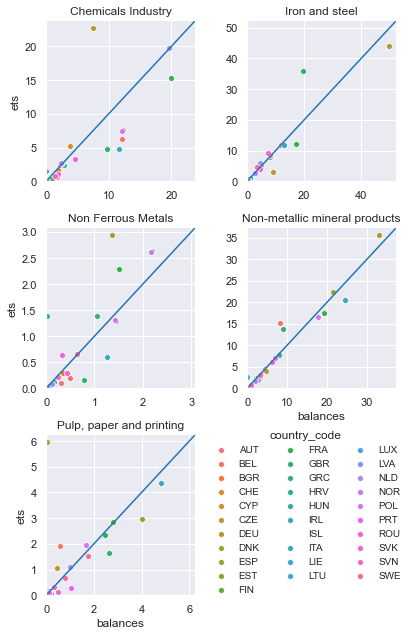

In [211]:
with sns.plotting_context("notebook", font_scale=1):
    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        bar.dropna(how='all').fillna(0).rename_axis(index=['subsector', 'country_code']).reset_index(),
        col='subsector',
        hue='country_code',
        hue_order=foo.index.levels[1],
        col_wrap=2,
        sharey=False,
        sharex=False
    )
    g.map(sns.scatterplot, 'balances', 'ets')
    g.add_legend(bbox_to_anchor=(0.32, 0.05), ncol=3, loc='lower left', fontsize='small')
    g.set_titles(col_template = '{col_name}')
    for i in g.axes:
        xlim = i.get_xlim()
        ylim = i.get_ylim()
        lim = max(xlim[1], ylim[1])
        i.set_xlim(0, lim)
        i.set_ylim(0, lim)
        i.add_line(mlines.Line2D([0, lim], [0, lim]))

In [244]:
foo = foo.drop('is_aut', axis=1)

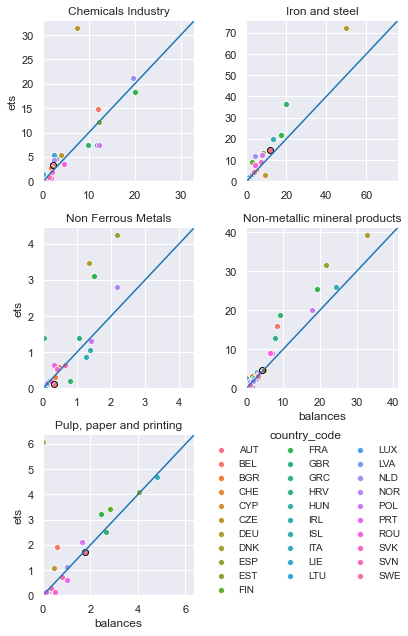

In [252]:
with sns.plotting_context("notebook", font_scale=1):
    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        foo.dropna(how='all').fillna(0).rename_axis(index=['subsector', 'country_code']).reset_index(),
        col='subsector',
        hue='country_code',
        hue_order=foo.index.levels[1],
        col_wrap=2,
        sharey=False,
        sharex=False
    )
    g.map(sns.scatterplot, 'balances', 'ets')
    g.add_legend(bbox_to_anchor=(0.32, 0.05), ncol=3, loc='lower left', fontsize='small')
    g.set_titles(col_template = '{col_name}')
    for i in g.axes:
        xlim = i.get_xlim()
        ylim = i.get_ylim()
        lim = max(xlim[1], ylim[1])
        i.plot(foo.loc[(i.get_title(), 'AUT'), 'balances'], foo.loc[(i.get_title(), 'AUT'), 'ets'], marker='o', mfc='None', mec='black', mew=1)
        i.set_xlim(0, lim)
        i.set_ylim(0, lim)
        i.add_line(mlines.Line2D([0, lim], [0, lim]))

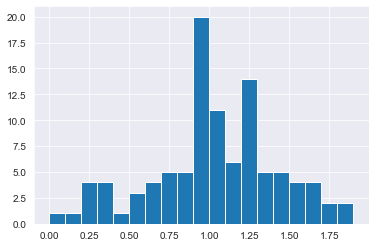

In [224]:
foo['ets'].div(foo.where(foo > 0)['balances']).hist(bins=[i/10 for i in range(20)])